In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 12:57:20.299509: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 12:57:21.697226: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 13200
end_idx = 13600
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(400, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(400, 96, 7)
(268800,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(400, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(400, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 12:57:30.318143: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:09:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 8

sol_per_pop = 64
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 12:57:33.491218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 4ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 3ms/step


13/13 [==============================] - 0s 4ms/step
CPU time: 6190.2721856141 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

13/13 [==============================] - 0s 3ms/step
Parameters of the best solution : [0.49399419 0.96510862 0.47798751 ... 0.65026882 0.39226027 0.25853817]
Fitness value of the best solution = 0.001819187847187749


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

13/13 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


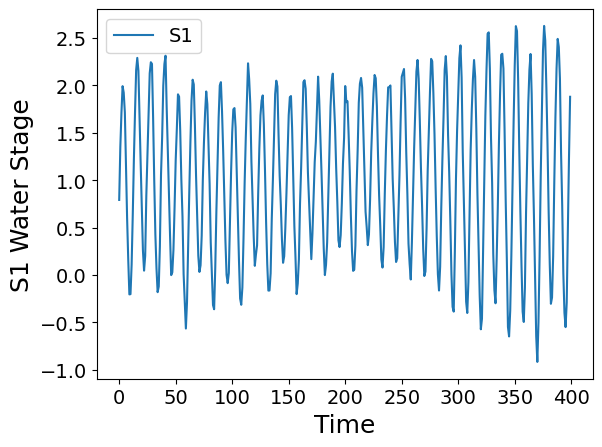

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low18.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.493994,0.965109,0.477988,0.360130,0.682843,0.507116,0.668267,0.464824,0.938231,0.580726,...,0.898987,0.335814,0.563767,0.110646,0.493284,0.016853,0.901545,0.143972,0.639177,0.646240
1,0.842219,0.013017,0.402624,0.853729,0.296163,0.045396,0.768902,0.407109,0.110703,0.443058,...,0.899999,0.326309,0.543679,0.652277,0.442524,0.988210,0.358937,0.366270,0.346074,0.971065
2,0.632581,0.703063,0.803297,0.774147,0.919924,0.465948,0.735836,0.215342,0.842521,0.687585,...,0.327093,0.935775,0.058563,0.251759,0.898502,0.167977,0.328338,0.290669,0.774178,0.574684
3,0.742513,0.822165,0.914986,0.768331,0.566713,0.644810,0.987971,0.647845,0.884653,0.807997,...,0.163404,0.772726,0.345044,0.665939,0.533350,0.134518,0.523718,0.491287,0.216962,0.301307
4,0.723824,0.577794,0.521042,0.414245,0.755452,0.037033,0.035409,0.987325,0.941442,0.416529,...,0.654123,0.700999,0.157589,0.837315,0.586430,0.378779,0.527182,0.699453,0.143455,0.728657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.819956,0.910918,0.771591,0.024710,0.338798,0.413846,0.454050,0.228408,0.846616,0.000187,...,0.835624,0.003145,0.434428,0.870588,0.563582,0.902706,0.691630,0.238138,0.228202,0.052429
396,0.725121,0.991321,0.355621,0.332780,0.932315,0.834233,0.292952,0.376856,0.983219,0.470850,...,0.053726,0.072928,0.701609,0.990695,0.257851,0.969552,0.138111,0.635451,0.864270,0.329794
397,0.293708,0.480106,0.030171,0.750236,0.983953,0.768910,0.263610,0.358627,0.182398,0.295821,...,0.659726,0.541687,0.306470,0.711578,0.469338,0.227468,0.037426,0.848156,0.569109,0.844800
398,0.580485,0.073786,0.997032,0.136137,0.958338,0.235550,0.955377,0.841582,0.767389,0.638926,...,0.511025,0.982703,0.877165,0.349056,0.441734,0.271802,0.499952,0.065665,0.992191,0.795546


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low18.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,0.791141,0.717086,0.684223,0.810806,1.326586,1.284294,1.216783,1.355419,1.815043,1.866095,...,0.516916,0.449374,0.295215,0.319887,0.417436,0.400066,0.270963,0.260276,0.288710,0.305392
1,1.351081,1.218732,1.323763,1.366633,1.768110,1.678247,1.639620,1.780678,2.043327,1.978501,...,0.282143,0.234015,0.319230,0.454259,0.421072,0.451636,0.752534,0.868000,0.817457,0.936676
2,1.713825,1.975120,1.744579,1.792940,1.996050,2.118499,1.985267,2.059189,2.090299,1.937602,...,0.421033,0.399113,0.772332,0.801365,0.821828,0.850298,1.241973,1.279884,1.213050,1.373778
3,1.991753,1.922395,2.000809,2.048806,2.070370,1.898245,2.050610,2.144972,1.783425,1.949226,...,0.728740,0.767250,1.161327,1.216524,1.092267,1.289155,1.496350,1.721336,1.438728,1.663489
4,1.923459,1.906281,1.996672,2.078026,1.735847,1.556284,1.776831,1.867460,1.166728,1.339883,...,1.165815,1.281183,1.588182,1.830978,1.458591,1.693135,1.948944,2.216036,1.873447,2.105204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,-0.550932,-0.555947,-0.466211,-0.577208,-0.297991,-0.291306,-0.307795,-0.323583,0.579613,0.676610,...,1.148270,1.206203,0.614406,0.632495,0.801150,0.784059,-0.065052,0.383775,0.281406,0.140877
396,-0.292691,-0.070587,-0.230674,-0.215295,0.503044,0.647356,0.493497,0.541066,1.129394,1.010917,...,0.764691,0.745953,0.013537,0.284235,0.268037,0.202465,-0.389518,-0.001623,-0.194842,-0.283967
397,0.489395,0.509872,0.462226,0.534624,1.150166,0.991674,1.011992,1.153283,1.922976,1.687205,...,0.146147,0.110958,-0.423512,-0.135734,-0.234305,-0.319357,-0.487950,-0.239057,-0.343585,-0.422799
398,1.230099,1.593802,1.316466,1.380578,1.874225,1.859037,1.871839,2.029895,2.478530,2.359218,...,-0.218852,-0.276945,-0.426631,-0.079762,-0.310822,-0.326767,-0.094071,0.013164,-0.053548,-0.051750


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 3221, areas: 772.8146943984202


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

13/13 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 5815, areas: 1670.0002665934007
